In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as hac

from private.ask_botometer import are_accounts_bots
from scripts import config as sconfig
from scripts import dataloaders as sdataloaders
from scripts.enums import Columns, Clusters, FactTypes
from scripts.validclustindicesmod import ValidClustMod
import scripts.cluster_utils as scluster_utils
from scripts import preprocessing as sprocessing
from scripts.path_utils import *
from scripts.utils import highlight_diag

In [3]:
np.random.seed(0)
config = sconfig.Config(date_from = '2020-01-22')
dl = sdataloaders.APILoader(config)
country_config = sconfig.CountryConfig(LABEL='ITA', TIME_ZONE='Europe/Rome')
processor = sprocessing.DataProcessor(config)
processor.load_and_prepare(dl, country_config)

ITA in store from 2020-01-22 to 2022-08-01. Store contains ['/ALL', '/DEU', '/ITA', '/ITA_preprocessed', '/NONE'].
Getting DF from Store for the dates 2020-01-22 to 2022-08-01
where_clause:  Datetime >= start_date & Datetime < end_date 
Completed loading DF of size  (18846723, 9)
Converting dateTime
Converting  Columns.YEAR
Converting  Columns.MONTH
Converting  Columns.MIN_BINS15
Finding posts per user


In [39]:
df = processor.all#.loc[~processor.all[Columns.VERIFIED.value]]
TYPE='all'

In [5]:
sns.set(rc={'figure.figsize':(7,5),
            'axes.facecolor':'white',
            'axes.edgecolor': 'black',
            'axes.spines.top': False,
            'axes.spines.right': False,
            'figure.facecolor':'white',
            'font.family': 'Helvetica',
            'xtick.bottom': True,
            'ytick.left': True,
            'xtick.color': 'black',
            'ytick.color': 'black',
            'legend.frameon': False
            })

# Pseudo-Chronotypes

We assume circadian variation on two levels: Variation in ratios of machinated content and variation in access to Twitter/capacity to tweet. We need to disentangle both effects.

## Aggregation
Ideally, we would model the time series continuously per each user over the time period that we have available, and then to separate seasonality/cyclical patterns, trend, and noise. This would allow us to isolate seasonality. However (1) that's resource-intense, (2) our data is so sparse it may not make much sense for all but the most active users and (3) few Twitter users are persistant, in that the inter-individual similarity in between subsequent days is small.

See the appendix for a comparison on aggregation over daily time intervals VS seasonal decomposition.

In [5]:
clusterer=scluster_utils.Clusterer(df, processor.posts_per_user, cutoff_post_nr=240, ratio_column=Columns.RATIO_BY_USER)

## Smoothing

We're trying to model one "standard" day for each user. Most Twitter users, however, don't necessarily post enough to fill all 15-minute bins with some value even if they are on Twitter, so we have to interpolate (this is not a problem for users who post a lot, as we've seen above).

We only have 24\*4=96 datapoints, meaning that we should not assume a distribution (we can't rely on the rule of large numbers either). So parametric fitting can lead to fitting a smooth curve that misrepresents the data. This leaves non-parametric smoothing methods like LOWESS or moving averages.

LOWESS/LOESS require fairly large, densely sampled data sets since they fit a model over local data structures, plus is sensitive to outliers. We just have one datapoint every 15 minutes. So moving average seems the better choice. Closed domain is sufficient for our use case, so we don't need EWA for responsiveness. Weighted moving average seemed a reasonable compromise between smoothing and data point consideration.

I chose the window size as 90 minutes because a) it gave good results and b) is suits the human ultradian rhythm.

Note that this is just for clustering: We'll apply Fourier smoothing afterwards on the aggregated curves.

In [6]:
smoothed_rhythms = clusterer.average_over_column()

Text(0.5, 0.98, 'Circadian rhythms throughout the day')

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


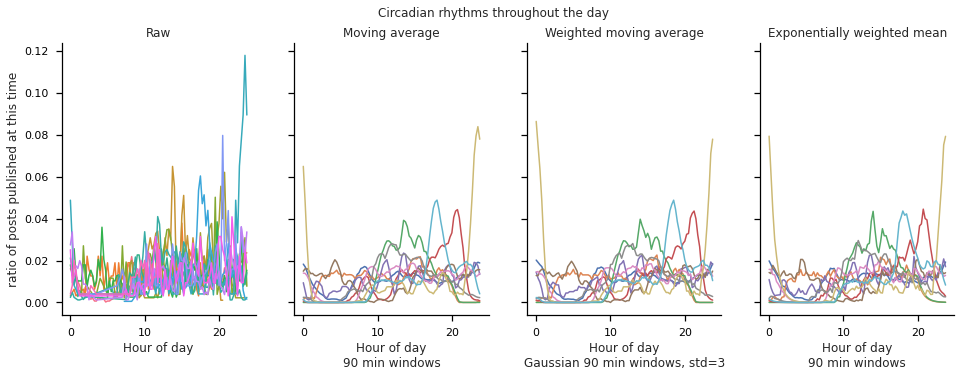

In [7]:
import matplotlib.font_manager
fig, axes = plt.subplots(1,4, figsize=(16, 5), sharey='all')
periods=24*4
g = sns.lineplot(
    data=(clusterer.smoothed_rhythms['raw']
          .reset_index()
          .loc[smoothed_rhythms['raw'].index.get_level_values(level="min_bins15") != "total"]
          .iloc[:10*periods]),
    hue="User", x="min_bins15", y=clusterer.ratio_column, legend=False, ax=axes[0])

g.set_title("Raw")
g.set_xlabel("Hour of day")
g.set_ylabel("ratio of posts published at this time")


for avg_df, ax in zip([clusterer.smoothed_rhythms[k] for k in "wma sma ewa".split()], axes[1:]):
    g = sns.lineplot(
        data=(avg_df
              .stack()
              .swaplevel()
              .sort_index()
              .reset_index().iloc[:10*periods]),
        hue="User", x="min_bins15", y=0, legend=False, ax=ax)
    g.set_xlabel("Hour of day\n90 min windows")
    g.set_ylabel("ratio of posts published at this time")
axes[1].set_title("Moving average")
axes[2].set_title("Weighted moving average")
axes[2].set_xlabel("Hour of day\nGaussian 90 min windows, std=3")
axes[3].set_title("Exponentially weighted mean")
fig.suptitle("Circadian rhythms throughout the day")

## Clustering

Let's compare hierarchical and kmeans clustering. We want at least 3 clusters for a sensible analysis. We can compare element-wise per index to find the more promising candidate.

Generally, we want to measure when people are awake, so it's important to collect all the Tweets. However, we should validate that the clusters found when considering all users are representative of Tweets by unverified users only.

In [8]:
vclust = ValidClustMod(
    indices = ['silhouette', 'calinski', 'davies', 'dunn', 'cop'],
    k=list(range(3, 10)),
    methods=['kmeans', 'hierarchical'],
    linkage="ward",
    affinity='euclidean',
)
vclust.add_index('distortion')

In [9]:
cvi_val_all, _ = scluster_utils.get_cluster_method(clusterer.smoothed_rhythms['wma'].transpose(), vclust=vclust)

Use hierarchical clustering.


Let's go for hierarchical clustering, as it beats kmeans in most combinations.
Here, I used agglomerative **Hierarchcal Clustering** with  **Ward's minimum variance method**. Ward's method minimizes total within-cluster variance, and is robust to noise (with no theoretical guarantees) https://jmlr.csail.mit.edu/papers/volume15/balcan14a/balcan14a.pdf
In agglomerative hierarchical clustering, each node (user) is a separate cluster. Clusters are then joined based on distance. As 2 clusters are merged, a dendrogram joins them in a graph by a branch. The height of the branch is the distance between those clusters.
Below you see the dendogram of clusters of users by their circadian rhythms.

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


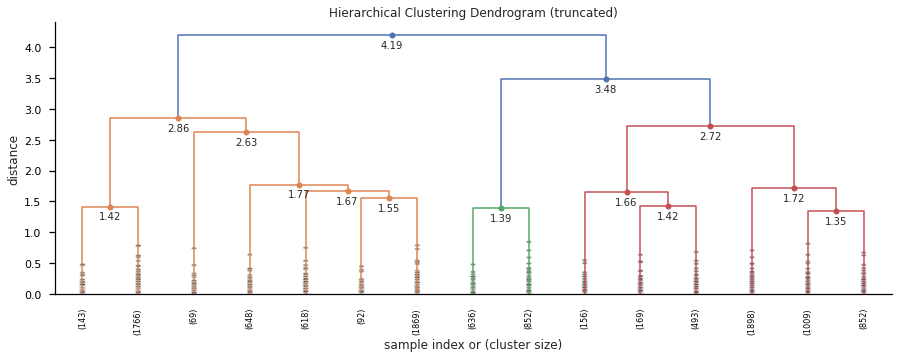

In [10]:
import matplotlib.font_manager
D = hac.linkage(clusterer.smoothed_rhythms['wma'].transpose(), "ward")
scluster_utils.plot_dendogram(D);

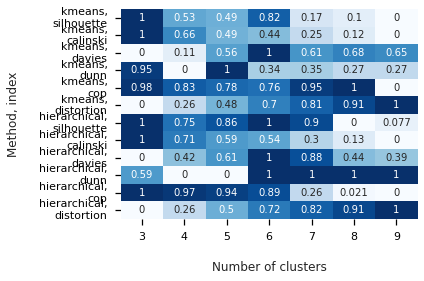

In [11]:
norm = vclust.plot()
cluster_size = norm.loc['hierarchical'].idxmax(axis=1)

In [12]:
print(', '.join([f'{v} {"votes" if v > 1 else "vote"} for {k} clusters' for k,v in cluster_size.value_counts().to_dict().items()]) + '.')
print(f'Majority vote for {cluster_size.value_counts().idxmax()}.')

3 votes for 6 clusters, 2 votes for 3 clusters, 1 vote for 9 clusters.
Majority vote for 6.


In [13]:
num_clusters = cluster_size.value_counts().idxmax()
avg, users, results = clusterer.process_clusters(D, clusterer.smoothed_rhythms['wma'].transpose(), num_clusters)

<AxesSubplot:xlabel='min_bins15'>

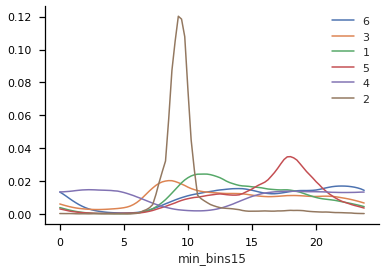

In [14]:
avg.plot()

Cluster 2 looks suspicious, like it might be inhabited by bots. Let's check.

Users per cluster:

In [15]:
results.value_counts()

6    3759
3    3227
1    1909
4    1488
5     818
2      69
dtype: int64

### Handling potential bots

In [16]:
potential_bot_users = {u for u, v in users.items() if v == results.value_counts().idxmin()}
botdict, bot_ratio = are_accounts_bots(potential_bot_users, config.USERHASH)
bot_ratio

0.5434782608695652

<AxesSubplot:xlabel='min_bins15', ylabel='TweetID'>

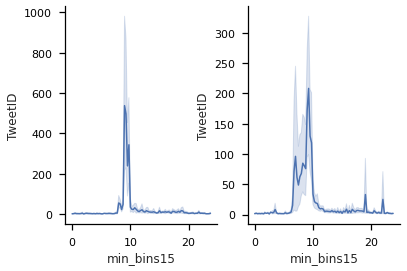

In [17]:
potential_bots_over_threshold = df.loc[
    (df[Columns.USER.value].isin(potential_bot_users)) & (df[Columns.USER.value].isin(botdict[True]))]
potential_bots_under_threshold = df.loc[
    (df[Columns.USER.value].isin(potential_bot_users)) & (~df[Columns.USER.value].isin(botdict[True]))]
fig, axes = plt.subplots(1,2)
sns.lineplot(data=potential_bots_over_threshold.groupby(["min_bins15", "User"]).count(), x="min_bins15", y="TweetID", ax=axes[0])
sns.lineplot(data=potential_bots_under_threshold.groupby(["min_bins15", "User"]).count(), x="min_bins15", y="TweetID", ax=axes[1])

More than half the users are suspected to the bots. The distributions of posts over the day by users classified as bots by botometer seem significantly more pin-pointed than those not classified as bots. Therefore, let's kick only the users classified as bots.

In [18]:
wma_no_bots=clusterer.smoothed_rhythms['wma'][[c for c in clusterer.smoothed_rhythms['wma'].columns if c not in botdict[True]]]

In [19]:
cvi_val_no_bots, _ = scluster_utils.get_cluster_method(wma_no_bots.transpose(), vclust=vclust)

Use hierarchical clustering.


In [20]:
D_no_bots = hac.linkage(wma_no_bots.transpose(), "ward")

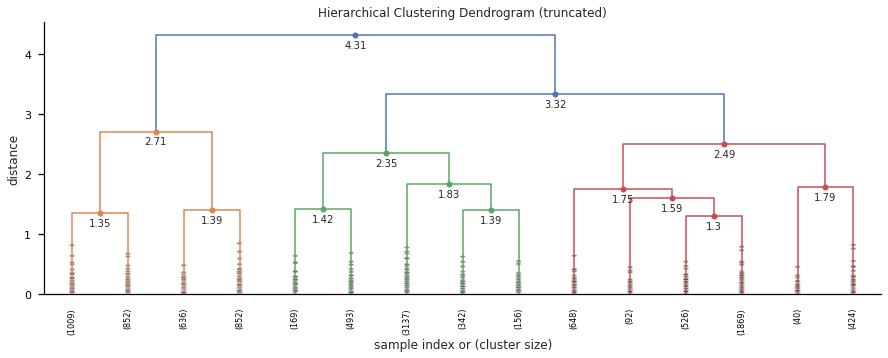

In [21]:
scluster_utils.plot_dendogram(D_no_bots);

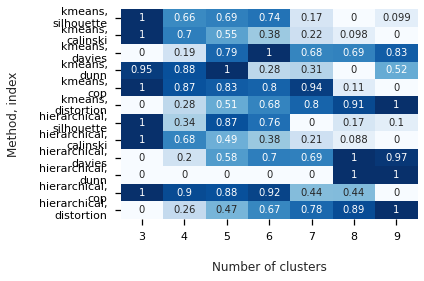

In [22]:
norm = vclust.plot()
cluster_size = norm.loc['hierarchical'].idxmax(axis=1)

In [23]:
print(', '.join([f'{v} {"votes" if v > 1 else "vote"} for {k} clusters' for k,v in cluster_size.value_counts().to_dict().items()]) + '.')
print(f'Majority vote for {cluster_size.value_counts().idxmax()}.')

3 votes for 3 clusters, 2 votes for 8 clusters, 1 vote for 9 clusters.
Majority vote for 3.


Cleaning up the bots yields a majority vote of CVIs for 3 clusters (inline with chronobiology's morning/intermediate/evening type)

In [24]:
num_clusters = cluster_size.value_counts().idxmax()
avg, users, results = clusterer.process_clusters(D_no_bots, wma_no_bots.transpose(), num_clusters)

<AxesSubplot:xlabel='min_bins15'>

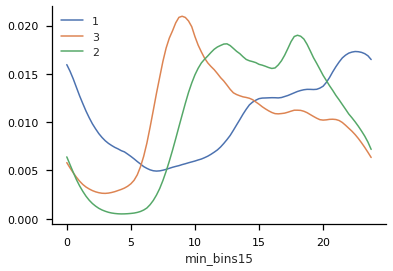

In [25]:
avg.plot()

### Assigning clusters

In [26]:
cluster_num_to_name = {
    None: Clusters.INFREQUENT.value,
    1: Clusters.EVENING.value,
    2: Clusters.INTERMEDIATE.value,
    3: Clusters.MORNING.value
}

usercol = df[Columns.USER.value].map(lambda x: scluster_utils.user_to_cluster(users, cluster_num_to_name, x, botdict))
df[Columns.CLUSTER.value] = "verified"
df[Columns.CLUSTER.value] = usercol.values

## Save aggregations

In [18]:
activity_path_manager = ActivityPathManager(config, country_config.LABEL, TYPE)
ratio_path_manager = MachinatedPathManager(config, country_config.LABEL, TYPE)
activity_rough=save_activity_per_cluster(df, activity_path_manager)
df[[Columns.CLUSTER.value]].to_parquet(get_cluster_col_path(activity_path_manager), compression='gzip')
machinated_per_cluster = save_machinated_per_cluster(df, ratio_path_manager)

## Cluster statistics

<AxesSubplot:xlabel='min_bins15', ylabel='activity'>

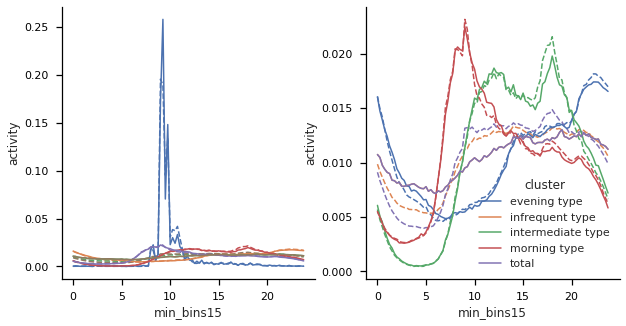

In [30]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
tmp = activity_rough.reset_index()
sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY.value, hue=Columns.CLUSTER.value, ls="--", ax=axes[0], legend=False, palette=Clusters.palette())
sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY_WEIGHTED.value, hue=Columns.CLUSTER.value, ax=axes[0], legend=False, palette=Clusters.palette())

tmp = tmp.loc[tmp[Columns.CLUSTER.value] !='bot']
ax = sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY.value, hue=Columns.CLUSTER.value, ls="--", palette=Clusters.palette() | {'bot':'black'})
sns.lineplot(data=tmp, x=Columns.MIN_BINS15.value, y=Columns.ACTIVITY_WEIGHTED.value, hue=Columns.CLUSTER.value, ax=ax, legend=False, palette=Clusters.palette())

<p id="SupplTab9">Supplementary Table 9</p>

In [33]:
cluster_stats = scluster_utils.get_user_stats(df)
cluster_stats

,posts,users,posts per user
infrequent type,7858209,860228,9.135030
intermediate type,4162911,4297,968.794741
morning type,3208484,3599,891.493193
evening type,2919309,3349,871.695730
bot,63313,25,2532.520000


In [34]:
activity_path_manager.to_latex(cluster_stats.style.format({'posts per user': '{:,.0f}'}, na_rep='-'), label='cluster_stats_total', caption="Statistics for each cluster.", is_multi_index=False)

In [148]:
infr_avg = scluster_utils.get_avg_for_cluster(df, wma_no_bots, Clusters.INFREQUENT.value)
distance_stats = scluster_utils.get_distance_stats(
    {v:k for k,v in cluster_num_to_name.items()}, wma_no_bots, results.values, infr_avg)

<p id="SupplTab10">Supplementary Table 10</p>

In [150]:
(distance_stats.T.loc[[Clusters.MORNING.value, Clusters.INTERMEDIATE.value, Clusters.EVENING.value, Clusters.INFREQUENT.value]]
 .style
 .format(lambda x: f'{x:.3f}')
 .apply(highlight_diag, axis=None))

,morning type,intermediate type,evening type
morning type,2.494,3.324,4.258
intermediate type,3.324,2.353,3.956
evening type,4.258,3.956,2.706
infrequent type,2.494,2.352,2.706


In [151]:
activity_path_manager.to_latex(
    distance_stats.T.loc[[Clusters.MORNING.value, Clusters.INTERMEDIATE.value, Clusters.EVENING.value, Clusters.INFREQUENT.value]].style
         .format(lambda x: f'{x:,.3f}')
         .apply(highlight_diag, axis=None),
    label= 'cluster_stats_distances',
    caption=r"Distances are given using Ward's variance minimization algorithm~\cite{Balcan2014Robust}.")

# Clustering users by Tweets with known reliability only

In [39]:
known_mask = processor.all[Columns.FACTTYPE.value]!=FactTypes.OTHER.value.name
known_posts_per_user = processor.all.loc[known_mask] \
    .groupby([Columns.USER.value]) \
    .agg({Columns.TWEET_ID.value: lambda x: x.count()})
known_posts_per_user.fillna(0, inplace=True)
known_posts_per_user.columns = [Columns.NUM_POSTS.value]

In [65]:
clusterer_known=scluster_utils.Clusterer(
    df.loc[df[Columns.FACTTYPE.value]!=FactTypes.OTHER.value.name],
    known_posts_per_user,
    cutoff_post_nr=240, ratio_column=Columns.RATIO_BY_USER)

In [66]:
clusterer_known.average_over_column();

In [67]:
wma_known=clusterer_known.smoothed_rhythms['wma'][[c for c in clusterer_known.smoothed_rhythms['wma'].columns if c not in botdict[True]]]

In [68]:
D_known = hac.linkage(wma_known.transpose(), "ward")

In [69]:
avg_known, users_known, results_known = clusterer_known.process_clusters(D_known, wma_known.transpose(), num_clusters)

<AxesSubplot:xlabel='min_bins15'>

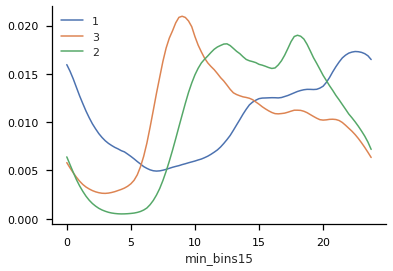

In [45]:
avg_known.plot()

# Clustering only unverified users

In [28]:
TYPE='unverified'
activity_path_manager = ActivityPathManager(config, country_config.LABEL, TYPE)
ratio_path_manager = MachinatedPathManager(config, country_config.LABEL, TYPE)

In [47]:
clusterer_unverified=scluster_utils.Clusterer(
    processor.all.loc[~processor.all[Columns.VERIFIED.value]],
    processor.posts_per_user,
    cutoff_post_nr=240, ratio_column=Columns.RATIO_BY_USER)

In [48]:
clusterer_unverified.average_over_column();

<AxesSubplot:xlabel='min_bins15'>

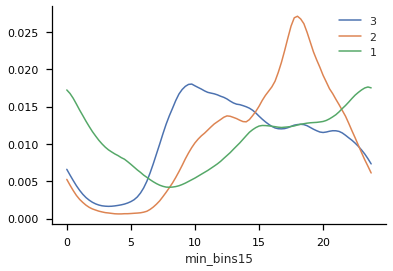

In [49]:
wma_unverified=clusterer_unverified.smoothed_rhythms['wma'][[c for c in clusterer_unverified.smoothed_rhythms['wma'].columns if c not in botdict[True]]]
D_unverified = hac.linkage(wma_unverified.transpose(), "ward")
avg_unverified, users_unverified, results_unverified = clusterer_unverified.process_clusters(D_unverified, wma_unverified.transpose(), num_clusters)
avg_unverified.plot()

The clusters solicited by unverified accounts only are relatively different. We can conclude that verified and unverified users differ significantly in their activity patterns.

In [50]:
unverified_cluster_num_to_name = {
    None: Clusters.INFREQUENT.value,
    1: Clusters.EVENING.value,
    2: Clusters.INTERMEDIATE.value,
    3: Clusters.MORNING.value
}

usercol_unverified = processor.all.loc[~processor.all[Columns.VERIFIED.value], Columns.USER.value].map(lambda x: scluster_utils.user_to_cluster(users_unverified, unverified_cluster_num_to_name, x, botdict));

In [30]:
usercol = pd.read_parquet(get_cluster_col_path(activity_path_manager))
df[Columns.CLUSTER.value] = "verified"
df[Columns.CLUSTER.value] = usercol.values

In [ ]:
activity_rough=save_activity_per_cluster(processor.all, activity_path_manager)
df[[Columns.CLUSTER.value]].to_parquet(get_cluster_col_path(activity_path_manager), compression='gzip')
machinated_per_cluster = save_machinated_per_cluster(processor.all, ratio_path_manager)

In [162]:
cluster_stats = scluster_utils.get_user_stats(processor.all)
cluster_stats

,posts,users,posts per user
infrequent type,7795201,858188,9.083326
morning type,5836455,6530,893.790965
evening type,2450328,2861,856.458581
intermediate type,1708929,1655,1032.585498
verified,359844,2624,137.135671
bot,61469,24,2561.208333


In [128]:
activity_path_manager.to_latex(
    cluster_stats.style.format({'posts per user': '{:.0f}'}, na_rep='-'),
    label='cluster_stats_total',
    caption=r"Statistics for each cluster.", is_multi_index=True)

In [132]:
infr_avg_unverified = scluster_utils.get_avg_for_cluster(processor.all.loc[~processor.all[Columns.VERIFIED.value]], wma_unverified, Clusters.INFREQUENT.value)
distance_stats = scluster_utils.get_distance_stats(
    {v:k for k,v in unverified_cluster_num_to_name.items()}, wma_unverified, results_unverified.values, infr_avg_unverified)

In [146]:
(distance_stats.T.loc[[Clusters.MORNING.value, Clusters.INTERMEDIATE.value, Clusters.EVENING.value, Clusters.INFREQUENT.value]]
 .style
 .format(lambda x: f'{x:.3f}')
 .apply(highlight_diag, axis=None))

,morning type,intermediate type,evening type
morning type,2.704,3.124,4.394
intermediate type,3.124,1.780,3.317
evening type,4.394,3.317,2.480
infrequent type,2.704,1.781,2.479


In [ ]:
activity_path_manager.to_latex(
    distance_stats.T.loc[[Clusters.MORNING.value, Clusters.INTERMEDIATE.value, Clusters.EVENING.value, Clusters.INFREQUENT.value]].style
    .format(lambda x: f'{x:.3f}')
    .apply(highlight_diag, axis=None),
    label= 'cluster_stats_distances',
    caption=r"Distances are given using Ward's variance minimization algorithm~\cite{Balcan2014Robust}.")

# Clustering only verified users

In [155]:
clusterer_verified=scluster_utils.Clusterer(
    processor.all.loc[processor.all[Columns.VERIFIED.value]],
    processor.posts_per_user,
    cutoff_post_nr=240, ratio_column=Columns.RATIO_BY_USER)

In [156]:
clusterer_verified.average_over_column();

<AxesSubplot:xlabel='min_bins15'>

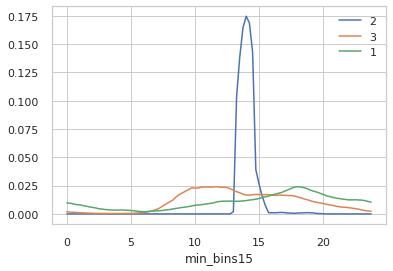

In [157]:
wma_verified=clusterer_verified.smoothed_rhythms['wma'][[c for c in clusterer_verified.smoothed_rhythms['wma'].columns if c not in botdict[True]]]
D_verified = hac.linkage(wma_verified.transpose(), "ward")
avg_verified, users_verified, results_verified = clusterer_verified.process_clusters(D_verified, wma_verified.transpose(), num_clusters)
avg_verified.plot()

In [163]:
verified_cluster_num_to_name = {
    None: Clusters.INFREQUENT.value,
    1: Clusters.EVENING.value,
    2: Clusters.INTERMEDIATE.value,
    3: Clusters.MORNING.value
}

usercol_verified = processor.all.loc[processor.all[Columns.VERIFIED.value], Columns.USER.value].map(lambda x: scluster_utils.user_to_cluster(users_verified, verified_cluster_num_to_name, x, botdict));

In [168]:
processor.all[Columns.CLUSTER.value] = "unverified"
processor.all.loc[processor.all[Columns.VERIFIED.value], Columns.CLUSTER.value] = usercol_verified.values

In [169]:
cluster_stats = scluster_utils.get_user_stats(processor.all)
cluster_stats.loc[['unverified'] + list(Clusters)]

,posts,users,posts per user
unverified,17852382,869258,20.537495
infrequent type,63008,2361,26.686997
morning type,207982,168,1237.988095
intermediate type,444,2,222.000000
evening type,86566,92,940.934783


Given that cluster 2 is only 2 users, we can likely ignore it.

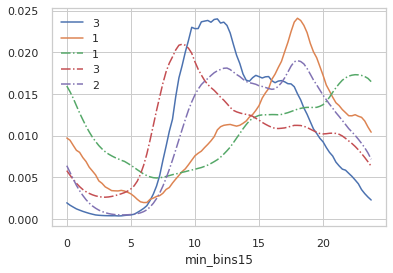

In [196]:
fig, ax = plt.subplots(1,1)
avg_verified[[3,1]].plot(ax=ax)
avg.plot(ax=ax, ls="-.")

cluster_map_verified_to_all = {1:2, 2:1, 3:3}

# Comparison

<AxesSubplot:xlabel='min_bins15'>

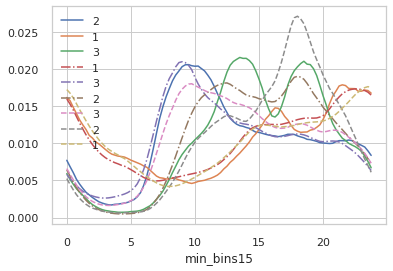

In [101]:
fig, ax = plt.subplots(1,1)
avg_known.plot(ax=ax)
avg.plot(ax=ax, ls="-.")
avg_unverified.plot(ax=ax, ls="--")

In [106]:
cluster_map_known_to_all = {1:1,2:3,3:2}
cluster_map_unverified_to_all = {1:1,3:3,2:2}
cluster_map_known_to_unverified = {1:1,2:3,3:2}

In [108]:
overlap = pd.DataFrame(0, columns=pd.MultiIndex.from_product((('known-all', 'unverified-all', 'known-unverified'), (1,2,3))), index=('overlap', 'difference'))
for user, cluster in users_known.items():
    c = cluster_map_known_to_all[cluster]
    l = 'overlap' if c == users[user] else 'difference'
    overlap.loc[l, ('known-all', c)] += 1
    if user in users_unverified:
        c = cluster_map_unverified_to_all[users_unverified[user]]
        l = 'overlap' if c == users[user] else 'difference'
        overlap.loc[l, ('unverified-all', c)] += 1
        c = cluster_map_known_to_unverified[cluster]
        l = 'overlap' if c == users[user] else 'difference'
        overlap.loc[l, ('known-unverified', c)] += 1

In [109]:
overlap

known-all             unverified-all            known-unverified  \
                   1     2     3              1    2     3                1   
overlap         1982  1771  2235           2504  918  3099             1969   
difference       980  1136  1857            260  250  2809              971   

                        
               2     3  
overlap     1739  2211  
difference  1119  1831

In [202]:
curve_features = pd.DataFrame(index=list(range(1,4)), columns=pd.MultiIndex.from_product([['MAX', 'MIN'], ['ALL', 'UNVERIFIED', 'KNOWN']]))
t=np.linspace(0, 24, 24 * 4, endpoint=False)
for i in iter(range(1,4)):
    for c, a, m in zip(
            ['ALL', 'UNVERIFIED', 'KNOWN'],
            [avg, avg_unverified, avg_known],
            [{1:1,2:2,3:3}, cluster_map_unverified_to_all, cluster_map_known_to_all]):
        curve_features.loc[i, ('MAX', c)] = t[a[m[i]].argmax()]
        curve_features.loc[i, ('MIN', c)] = t[a[m[i]].argmin()]

In [203]:
curve_features

MAX                    MIN                 
    ALL UNVERIFIED KNOWN   ALL UNVERIFIED KNOWN
1  22.5       23.5  21.5   7.0        8.0  9.75
2  18.0       18.0  13.5  4.25        4.0  4.25
3   9.0       9.75   9.5   3.0       3.25   3.5